In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [12]:
import scanpy as sc

adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_and_ztrans\Hao_Harmony_test_no_scale.h5ad")
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [13]:
# Briefly view adata.X (raw counts)
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.4895154535770416
Row 0, Column 43, Value 0.8167138695716858
Row 0, Column 48, Value 0.8167138695716858
Row 0, Column 53, Value 0.8167138695716858
Row 0, Column 55, Value 1.424944519996643
Row 0, Column 66, Value 0.4895154535770416
Row 0, Column 77, Value 0.8167138695716858
Row 0, Column 78, Value 1.424944519996643
Row 0, Column 89, Value 0.8167138695716858
Row 0, Column 93, Value 1.0628387928009033
Row 0, Column 102, Value 0.8167138695716858
Row 0, Column 154, Value 2.4626553058624268
Row 0, Column 178, Value 0.8167138695716858
Row 0, Column 185, Value 0.4895154535770416
Row 0, Column 190, Value 0.4895154535770416
Row 0, Column 201, Value 1.8004224300384521
Row 0, Column 224, Value 0.8167138695716858
Row 0, Column 240, Value 0.4895154535770416
Row 0, Column 259, Value 0.4895154535770416
Row 0, Column 261, Value 1.566353440284729


## Scale genes

In [14]:
# Scale each gene to unit variance
sc.pp.scale(adata)

In [15]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [16]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_v2\Level1\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [17]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [18]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,17,16
CD4_T,1719,813
CD8_T,7,5
DC,1250,579
Mono,73,65
NK,232,127
other,380,205
other_T,1097,568


## Build classifiers (K-fold CV)

In [19]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [20]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_v2\Level1\LR_classifiers_scaled")

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_Harmony_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B
[0.999313816754305, 0.9975292474837829, 0.9944202898550725, 0.9959687920762844, 0.9999534063760072, 0.9995866989717008, 0.9955973545646526]
K-fold CV for: CD4_T
[0.9893734293448663, 0.9784782833115017, 0.9798297530640225, 0.9790986324349973, 0.9987731280315625, 0.9961340748550276, 0.9720241544443718]
K-fold CV for: CD8_T
[0.9694122478517533, 0.9306963872209204, 0.8705097899909735, 0.899571583885605, 0.9859140717914199, 0.9525596222338126, 0.8822575364192919]
K-fold CV for: DC
[0.9981701744446607, 0.9622141371362, 0.9551396059874981, 0.958609904544204, 0.999704030369346, 0.9927032753398034, 0.9577093505765214]
K-fold CV for: Mono
[0.9935956080722781, 0.9843366261576177, 0.9946949602122016, 0.9894858436516449, 0.9987056024387908, 0.9952069150915145, 0.984912315687479]
K-fold CV for: NK
[0.9978363522838734, 0.9914183521634357, 0.989819873673838, 0.9906167986814207, 0.9998176206997009, 0.9985277540369497, 0.98939547247076]
K-fold CV for: other
[0.9942261602146425, 0.942325

In [21]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999314,0.997529,0.994420,0.995969,0.999953,0.999587,0.995597
CD4_T,0.989373,0.978478,0.979830,0.979099,0.998773,0.996134,0.972024
CD8_T,0.969412,0.930696,0.870510,0.899572,0.985914,0.952560,0.882258
DC,0.998170,0.962214,0.955140,0.958610,0.999704,0.992703,0.957709
Mono,0.993596,0.984337,0.994695,0.989486,0.998706,0.995207,0.984912
NK,0.997836,0.991418,0.989820,0.990617,0.999818,0.998528,0.989395
other,0.994226,0.942325,0.775676,0.849602,0.957236,0.873697,0.851536
other_T,0.990158,0.901678,0.859180,0.879836,0.993505,0.936450,0.875029


In [23]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_L1.csv')

## Read saved .pkl

## Plot classifier K-fold CV metrics

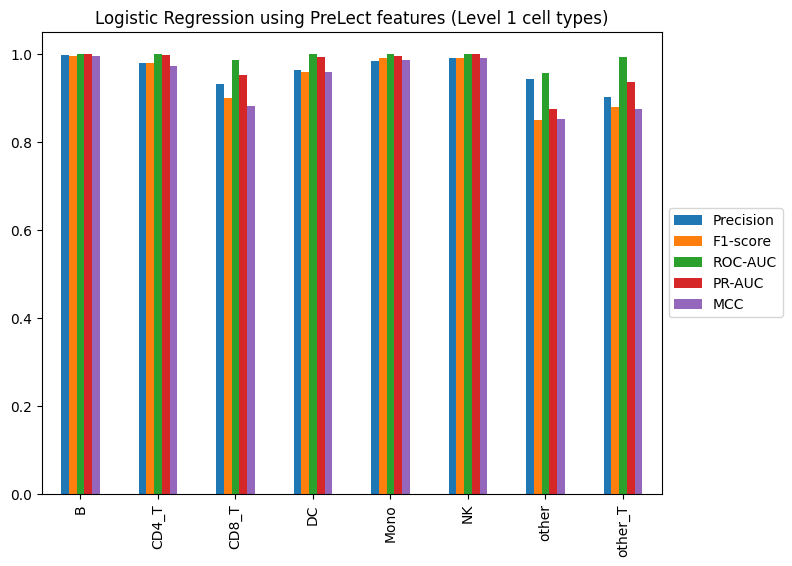

In [25]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(8,6), title='Logistic Regression using PreLect features (Level 1 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))